In [1]:
# Get data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 42

features, target = load_wine(return_X_y=True)

# Make a train/test split using 30% test size
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.30, random_state=RANDOM_STATE
)

# scaling data to have mean zero and standard deviation 1
# this worked better than 0-1 normalisation
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

# transpose to fit (features,examples) shape expected in this notebook
X_train=X_train.T
X_test=X_test.T

# add a row of ones for multiplication with bias term
X_train = np.concatenate((np.ones((1,X_train.shape[1])),X_train))
X_test = np.concatenate((np.ones((1,X_test.shape[1])),X_test))

n_examples=X_train.shape[1]
n_class=len(np.unique(y_train))


In [2]:
# Defind some function
def one_hot_encode(y):
    n_class=len(np.unique(y))
    y_one_hot = np.zeros((n_class,len(y)))
    for i in range(n_class):
        y_one_hot[i] = (y==i)
    return y_one_hot
def one_hot_encode(y):
    n_class=len(np.unique(y))
    return np.eye(n_class)[y].T
test = np.array([0, 1, 3, 2, 2, 2])

def softmax(X):
    X = np.exp(X)
    return X/np.expand_dims(np.sum(X, axis = 0),axis=0)

def multiclass_entropy_loss(X, y, epsilon = 1e-5):
    X_log = np.log(X+epsilon)
    return -np.sum(y*X_log, axis=0).mean()


def multiclass_forward(W,X):
    Z1 = W@X
    F1 = softmax(Z1)
    L = multiclass_entropy_loss(F1)
    return L


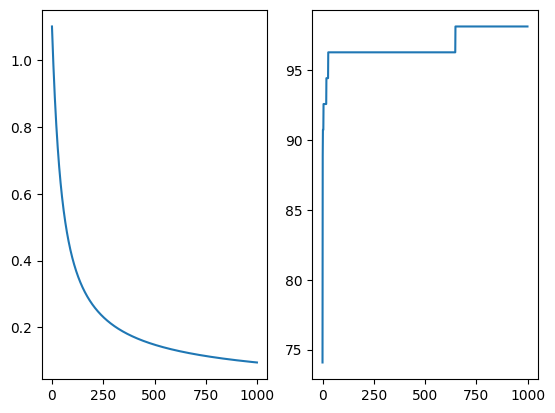

In [3]:
# Single neuron
y_train_hot = one_hot_encode(y_train)
y_test_hot = one_hot_encode(y_test)
W = np.random.random(size=(3,14))/1e2
train_step = 1e-2

loss_list = []
accuracy_list = []
epochs = 1000
for i in range(epochs):
    # Run the forward
    Z1 = W@X_train
    F1 = softmax(Z1)
    L = multiclass_entropy_loss(F1, y_train_hot)
    loss_list.append(L)

    # Run the backward
    dL_dZ1 = F1 - y_train_hot
    dL_dW = np.expand_dims(dL_dZ1, axis = 1)*np.expand_dims(X_train, axis = 0)
    W += -train_step*np.mean(dL_dW, axis=-1)

    # Test
    Z1 = W@X_test
    F1 = softmax(Z1)
    predict = np.argmax(F1, axis=0)
    accuracy = (predict == y_test).mean()*100
    accuracy_list.append(accuracy)

plt.subplot(1,2,1)
plt.plot(loss_list)
plt.subplot(1,2,2)
plt.plot(accuracy_list)

In [6]:
def leak_ReLu(X, alpha=0.01):
    return alpha*X + (X>=0)*(1-alpha)*X
test = np.array([0, 1, 3, -2, -2, 2])
leak_ReLu(test)


array([ 0.  ,  1.  ,  3.  , -0.02, -0.02,  2.  ])

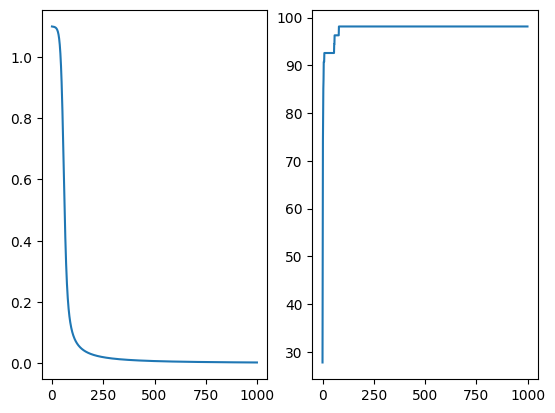

In [7]:
# 1 fully connected layer + leakyReLu + 1 ouput layer + softmax
y_train_hot = one_hot_encode(y_train)
y_test_hot = one_hot_encode(y_test)
W1 = np.random.random(size=(14,14))/1e2
W2 = np.random.random(size=(3,14))/1e2
train_step = 1e-2
alpha=0.01

loss_list = []
accuracy_list = []
epochs = 1000
for i in range(epochs):
    # Run the forward
    Z1 = W1@X_train
    F1 = leak_ReLu(Z1,alpha=alpha)
    Z2 = W2@F1
    F2 = softmax(Z2)
    L = multiclass_entropy_loss(F2, y_train_hot)
    loss_list.append(L)

    # Run the backward
    dL_dZ2 = F2 - y_train_hot
    dL_dW2 = np.expand_dims(dL_dZ2, axis = 1)*np.expand_dims(F1, axis = 0)
    dL_dF1 = W2.T@dL_dZ2
    dF1_dZ1 = alpha + (Z1>=0)*(1-alpha)
    dL_dZ1 = dL_dF1*dF1_dZ1
    dL_dW1 = np.expand_dims(dL_dZ1, axis = 1)*np.expand_dims(X_train, axis = 0)
    dL_dW1 = np.sum(dL_dW1, axis=2)
    W2 += -train_step*np.mean(dL_dW2, axis=-1)
    W1 += -train_step*dL_dW1

    # Test
    Z1 = W1@X_test
    F1 = leak_ReLu(Z1,alpha=alpha)
    Z2 = W2@F1
    F2 = softmax(Z2)
    predict = np.argmax(F2, axis=0)
    accuracy = (predict == y_test).mean()*100
    accuracy_list.append(accuracy)

plt.subplot(1,2,1)
plt.plot(loss_list)
plt.subplot(1,2,2)
plt.plot(accuracy_list)
